# Dijet Selection Example Processor

We create a dijet selection that selects events that have at least 2 jets with: 
* $p_{T} > 200 GeV$
* $|\eta| < 2.5$
* "Loose" jet ID

The selection then imposes two topological selections : 
* $\Delta \phi > 2$
* $\frac{p_{T,1} - p_{T,2}}{p_{T,1} + p_{T,2}} < 0.3$

In [1]:
import awkward as ak
import numpy as np
import time
import coffea
import uproot
import hist
print(coffea.__version__)
from coffea import util, processor
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema, BaseSchema
from collections import defaultdict

0.7.18


## Create the coffea Processor

In [2]:
class DijetHists(processor.ProcessorABC):
    def __init__(self, ptcut=200., etacut = 2.5):
        # should have separate lower ptcut for gen
        self.ptcut = ptcut
        self.etacut = etacut
        
        dataset_axis = hist.axis.StrCategory([], growth=True, name="dataset", label="Primary dataset")
        mass_axis = hist.axis.Regular(100, 0, 1000, name="mass", label=r"$m$ [GeV]")
        pt_axis = hist.axis.Regular(150, 0, 1500, name="pt", label=r"$p_{T}$ [GeV]")        
        h_pt1 = hist.Hist(dataset_axis, pt_axis, storage="weight", label="Counts")
        h_pt2 = hist.Hist(dataset_axis, pt_axis, storage="weight", label="Counts")        
        
        cutflow = defaultdict(int)
        
        self.hists = {
            "pt1":h_pt1, "pt2":h_pt2, "cutflow":cutflow
        }
        
    
    @property
    def accumulator(self):
        return self._histos
    
    # we will receive a NanoEvents instead of a coffea DataFrame
    def process(self, events):
        dataset = events.metadata['dataset']
        
        
        # Select all jets that satisfy pt, eta, and jet ID cuts
        events.FatJet = events.FatJet[ 
            (events.FatJet.pt > self.ptcut) & 
            (np.abs(events.FatJet.eta) < self.etacut) &
            (events.FatJet.jetId > 0)]

        # Require at least two such jets per event
        dijetEvents = events[(ak.num(events.FatJet) >= 2)]
        
        # Get the leading and subleading jets
        jet1 = dijetEvents.FatJet[:,0]
        jet2 = dijetEvents.FatJet[:,1]
        
        # Select events with delta phi and asymmetry cuts
        dphi12_cut = (np.abs(jet1.delta_phi(jet2)) > 2.)
        asymm_cut = (np.abs(jet1.pt - jet2.pt)/(jet1.pt + jet2.pt) < 0.3)        
        dijetEvents = dijetEvents[ asymm_cut & dphi12_cut ]
        
        # Get the leading and subleading jets of the events that pass selection
        jet1 = dijetEvents.FatJet[:,0]
        jet2 = dijetEvents.FatJet[:,1]
        
        # Make plots
        self.hists["pt1"].fill(dataset=dataset, pt = jet1.pt)
        self.hists["pt2"].fill(dataset=dataset, pt = jet2.pt)

        return self.hists
    
    def postprocess(self, accumulator):
        return accumulator

## Run the processor over desired files

In [3]:

import time

tstart = time.time()



fileset = {
    'JetHT': [
        '/mnt/data/cms/store/data/Run2016B/JetHT/NANOAOD/ver1_HIPM_UL2016_MiniAODv2_NanoAODv9-v2/40000/2B449ED9-2A70-6D4D-9AEB-B2870545D35B.root',
    ]
}


run = processor.Runner(
    executor = processor.FuturesExecutor(compression=None, workers=4),
    schema=NanoAODSchema,
    chunksize=100_000,
    # maxchunks=10,  # total 676 chunks
)

output = run(
    fileset,
    "Events",
    processor_instance=DijetHists(),
)


Output()

Output()

## Make plots

In [4]:
import matplotlib.pyplot as plt

(1, 392.99191978575715)

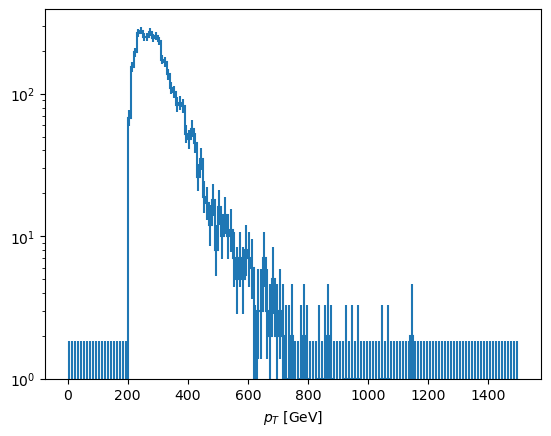

In [5]:
fig, ax = plt.subplots()
output['pt1'].plot1d(ax=ax, overlay='dataset')
ax.set_yscale('log')
ax.set_ylim(1, None)